In [1]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="5EgHNeO8aCt8ZFfShQsK")
# project = rf.workspace("shehan-sudeepa-perera").project("letters-recognition-kqgx4")
# version = project.version(1)
# dataset = version.download("multiclass")


In [ ]:
# import os
# from PIL import Image
# import cv2 as cv
# import numpy as np

# def gamma_correction(image_path, gamma=0.2, save_path=None):
#     image = Image.open(image_path).convert('RGB')

#     # PIL → OpenCV (RGB → BGR)
#     image = np.array(image)[:, :, ::-1]
#     image_lab = cv.cvtColor(image, cv.COLOR_BGR2Lab)

#     # Gamma LUT
#     G = np.array([((i / 255) ** (1 / gamma)) * 255 for i in range(256)]).astype("uint8")
#     image_lab[:, :, 0] = cv.LUT(image_lab[:, :, 0], G)

#     # Back to RGB
#     corrected = cv.cvtColor(image_lab, cv.COLOR_Lab2BGR)[:, :, ::-1]
#     corrected_image = Image.fromarray(corrected)

#     if save_path:
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#         corrected_image.save(save_path)

#     return corrected_image

# # Base path
# base_path = r"D:/My Projects/Drone Competition/Drone/letters-recognition-1"
# folders = ["train", "valid", "test"]
# gamma = 0.2

# for folder in folders:
#     input_dir = os.path.join(base_path, folder)
#     output_dir = os.path.join(base_path, folder + "_corrected")

#     for img_name in os.listdir(input_dir):
#         # Only process image files
#         if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
#             continue
#         img_path = os.path.join(input_dir, img_name)
#         save_path = os.path.join(output_dir, img_name)
#         gamma_correction(img_path, gamma=gamma, save_path=save_path)

# print("✅ All images preprocessed and saved in *_corrected folders.")

✅ All images preprocessed and saved in *_corrected folders.


In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import torch
print(torch.__file__)
print(torch.cuda.is_available())
print(torch.version.cuda)

c:\Users\ASUS\miniconda3\envs\torch_env\lib\site-packages\torch\__init__.py
True
12.1


In [4]:
# classification model
class Letter_recognition(nn.Module):
    def __init__(self):
        super(Letter_recognition, self).__init__()

        self.features = nn.Sequential(
            # layer 1
            nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #layer 2
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #layer 3
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the input size for the first fully connected layer
        # based on the output shape of the convolutional layers.
        # We can do this by passing a dummy tensor through the features
        # and checking its shape.
        dummy_input = torch.randn(1, 3, 64, 64, device=next(self.parameters()).device) # Assuming input images are 128x128
        output_size = self.features(dummy_input).flatten(1).shape[1]

        self.fully_connected = nn.Sequential(
            nn.Linear(output_size, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 9))

    def forward(self, x):
        x = self.features(x)
        X = torch.flatten(x, 1)
        X = self.fully_connected(X)

        return X

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import cv2 as cv

class LetterDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):

        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get one-hot label and convert to class index
        one_hot = self.data.iloc[idx, 1:].values.astype('float32')
        label = torch.tensor(one_hot).argmax()  # convert one-hot to integer class

        return image, label

from torchvision import transforms




transform = transforms.Compose([
    transforms.Resize((64, 64)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])




In [6]:
batch_size = 32

train_dataset = LetterDataset(csv_file='letters-recognition-1/train/_classes.csv', img_dir='letters-recognition-1/train_corrected', transform=transform)
val_dataset   = LetterDataset(csv_file='letters-recognition-1/valid/_classes.csv', img_dir='letters-recognition-1/valid_corrected', transform=transform)
test_dataset  = LetterDataset(csv_file='letters-recognition-1/test/_classes.csv', img_dir='letters-recognition-1/test_corrected', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [7]:
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Train samples: 1338
Val samples: 90
Test samples: 59


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Letter_recognition().to(device)
# print("Device used:", device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# EPOCHS = 15
# train_losses, val_losses = [], []
# train_accs, val_accs = [], []

# for epoch in range(EPOCHS):
#     # ---- TRAIN ----
#     model.train()
#     total_loss, correct = 0, 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         correct += (outputs.argmax(1) == labels).sum().item()

#     train_loss = total_loss / len(train_loader)
#     train_acc = correct / len(train_dataset)

#     # ---- VALIDATION ----
#     model.eval()
#     total_loss, correct = 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             print("images:", images.device, "labels:", labels.device, "model:", next(model.parameters()).device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             total_loss += loss.item()
#             correct += (outputs.argmax(1) == labels).sum().item()

#     val_loss = total_loss / len(val_loader)
#     val_acc = correct / len(val_dataset)

#     # Save for plotting
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_accs.append(train_acc)
#     val_accs.append(val_acc)

#     print(f"Epoch {epoch+1}/{EPOCHS} "
#           f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, "
#           f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")


# # -------------------------
# # Plot Loss & Accuracy
# # -------------------------
# plt.figure(figsize=(12,5))

# plt.subplot(1,2,1)
# plt.plot(train_losses, label="Train Loss")
# plt.plot(val_losses, label="Val Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Loss Curve")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(train_accs, label="Train Acc")
# plt.plot(val_accs, label="Val Acc")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Accuracy Curve")
# plt.legend()

# plt.show()


Model initialized and moved to device: cuda
✅ Best model saved with val_acc=0.444
Epoch 1/15 Train Loss: 2.158, Train Acc: 0.286, Val Loss: 1.698, Val Acc: 0.444
✅ Best model saved with val_acc=0.611
Epoch 2/15 Train Loss: 1.459, Train Acc: 0.466, Val Loss: 1.311, Val Acc: 0.611
Epoch 3/15 Train Loss: 1.067, Train Acc: 0.624, Val Loss: 1.202, Val Acc: 0.600
✅ Best model saved with val_acc=0.756
Epoch 4/15 Train Loss: 0.743, Train Acc: 0.753, Val Loss: 0.854, Val Acc: 0.756
✅ Best model saved with val_acc=0.811
Epoch 5/15 Train Loss: 0.429, Train Acc: 0.865, Val Loss: 0.732, Val Acc: 0.811
✅ Best model saved with val_acc=0.822
Epoch 6/15 Train Loss: 0.275, Train Acc: 0.908, Val Loss: 0.721, Val Acc: 0.822
Epoch 7/15 Train Loss: 0.210, Train Acc: 0.936, Val Loss: 0.597, Val Acc: 0.822
✅ Best model saved with val_acc=0.833
Epoch 8/15 Train Loss: 0.118, Train Acc: 0.959, Val Loss: 0.706, Val Acc: 0.833
✅ Best model saved with val_acc=0.844
Epoch 9/15 Train Loss: 0.106, Train Acc: 0.960, Va

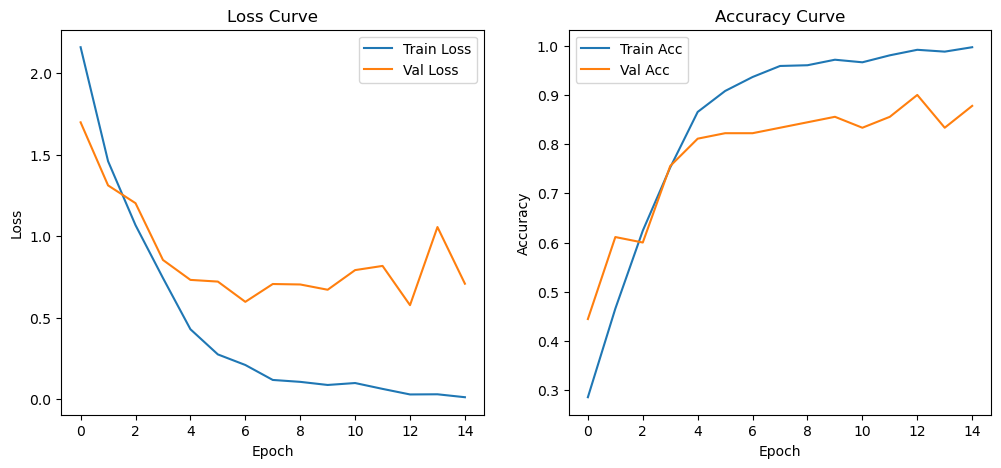

In [9]:
best_val_acc = 0.0
save_path_pth = "letter_cnn_best.pth"
save_path_pt  = "letter_cnn_best.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Letter_recognition().to(device)

print("Model initialized and moved to device:", device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 15
train_losses, val_losses = [], []
train_accs, val_accs = [], []


for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct / len(train_dataset)

    # ---- VALIDATION ----
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    val_loss = total_loss / len(val_loader)
    val_acc = correct / len(val_dataset)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path_pth)   # weights only
        torch.save(model, save_path_pt)                 # full model
        print(f"✅ Best model saved with val_acc={val_acc:.3f}")
    # Save for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, "
          f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")

# -------------------------
# Plot Loss & Accuracy
# -------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [10]:
# Load best model before testing
model.load_state_dict(torch.load(save_path_pth))
model.eval()

test_loss, test_correct = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = outputs.argmax(1)
        test_correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = test_correct / len(test_dataset)

print(f"📊 Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29588\3433383872.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path_pth))


📊 Test Loss: 0.659, Test Accuracy: 0.881


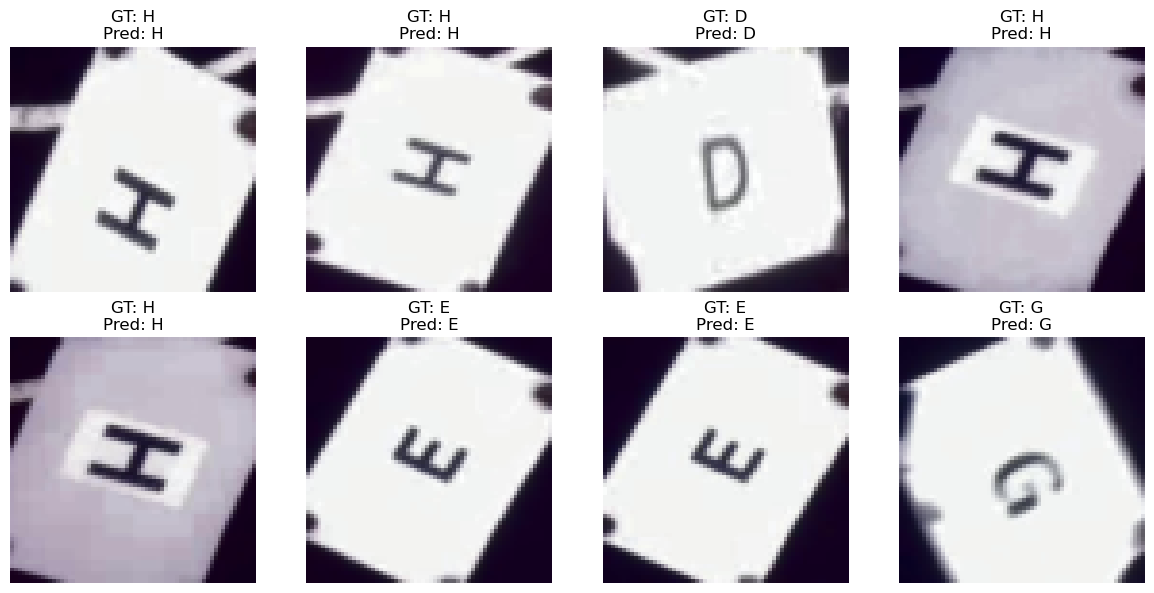

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Class names (adjust to your dataset order)
class_names = ["A","B","C","D","E","F","G","H","I"]

# Get a batch of test data
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(1)

# Plot first 8 test images with GT and predictions
plt.figure(figsize=(12, 6))
for i in range(8):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)  # de-normalize

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"GT: {class_names[labels[i].item()]}\nPred: {class_names[preds[i].item()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


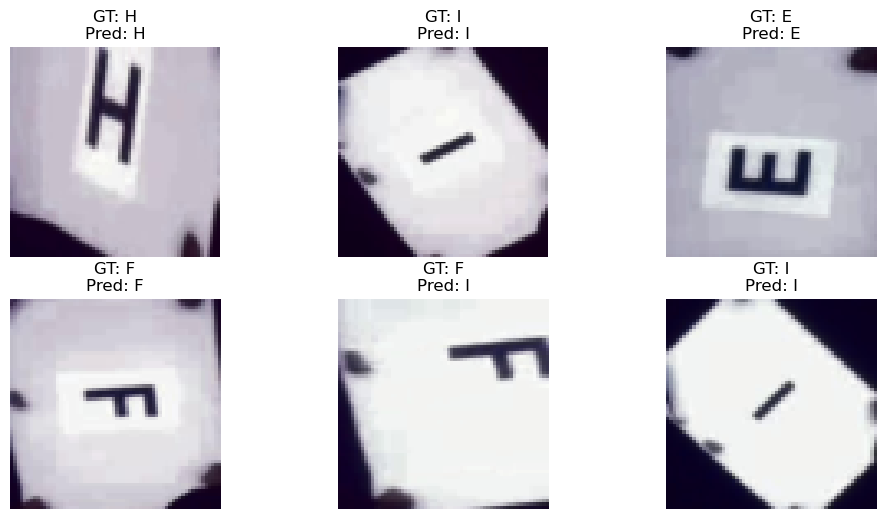

In [19]:
import random

# get one random batch
rand_batch = random.choice(list(test_loader))
images, labels = rand_batch
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    preds = model(images).argmax(1)

# plot 6 random samples from this batch
plt.figure(figsize=(12, 6))
for i in range(6):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)  # de-normalize

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"GT: {class_names[labels[i].item()]}\nPred: {class_names[preds[i].item()]}")
    plt.axis("off")
plt.show()
